In [1]:
import os
import time
import math
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.cluster import KMeans
from tqdm import tqdm
import seaborn as sns
import pandas as pd

In [2]:
# initialise stream from video
frames = []
dir_path = 'videos'
filename = 'SAL.mp4'
cap = cv.VideoCapture(os.path.join(dir_path, filename))
ret, prvs = cap.read()
frames.append(prvs)

# main loop
count = 0
flows = []
while True:
    # read a new frame
    ret, nxt = cap.read()
    
    if not ret or count == 5:
        break
    else:
        count += 1
    frames.append(nxt)
        
    # if the image is colored
    if len(prvs.shape) == 3:
        prvs_gray = cv.cvtColor(prvs.copy(), cv.COLOR_BGR2GRAY)
        next_gray = cv.cvtColor(nxt.copy(), cv.COLOR_BGR2GRAY)
    else:
        prvs_gray = prvs.copy()
        next_gray = nxt.copy()

    # calculate optical flow
    flow = cv.calcOpticalFlowFarneback(prvs_gray, next_gray, None, 0.5, 3, 16, 3, 5, 1.2, 0)
    flows.append(flow)
    prvs = nxt.copy()

In [3]:
# round flows to the nearest integer
flows = np.rint(flows).astype(np.int32)

In [4]:
def get_macroblocks_vectors(flow, macroblock_size):
    width = len(flow[0])
    height = len(flow)

    macroblocks = np.zeros(
        (height // macroblock_size + int(height % macroblock_size != 0),
        width // macroblock_size + int(width % macroblock_size != 0),
                            2))
    print(macroblocks.shape)
    for y in range(0, height , macroblock_size):
        for x in range(0, width, macroblock_size):

            bw = macroblock_size if x + macroblock_size <= width else width - x
            bh = macroblock_size if y + macroblock_size <= height else height - y
            # current block
            cur_block = np.array([ i[x:x+bw] for i in flow[y:y + bh]])
            # get mean vector
            # flatten current block to make process easier
            mean = cur_block.reshape(-1, cur_block.shape[-1]).mean(axis = 0)
            macroblocks[y//macroblock_size + int(y % macroblock_size != 0)][x//macroblock_size + int(x % macroblock_size != 0)] = mean

    return macroblocks
# flow0_macroblock = get_macroblocks_vectors(flows[-1], 16)
# flow0_macroblock.shape

In [5]:
# convert pixel flow to block flow
block_flow = get_macroblocks_vectors(flows[-1], 16)

(68, 120, 2)


In [6]:
from sklearn.cluster import DBSCAN

# total_inliers = np.array([tuple(inlier) for inlier in flows[-1].reshape(-1, flows[-1].shape[-1])])
# total_k_means = KMeans(n_clusters=2, random_state=0).fit(total_inliers)
# algorithm = {“lloyd”, “elkan”, “auto”, “full”}
blocks_inliers = np.array([tuple(inlier) for inlier in block_flow.reshape(-1, block_flow.shape[-1])])
blocks_k_means = DBSCAN(eps=0.1, min_samples=4).fit(blocks_inliers)

In [15]:
from sklearn.neighbors import NearestNeighbors
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros)
nbrs = NearestNeighbors(n_neighbors=5).fit(blocks_inliers)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(blocks_inliers)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

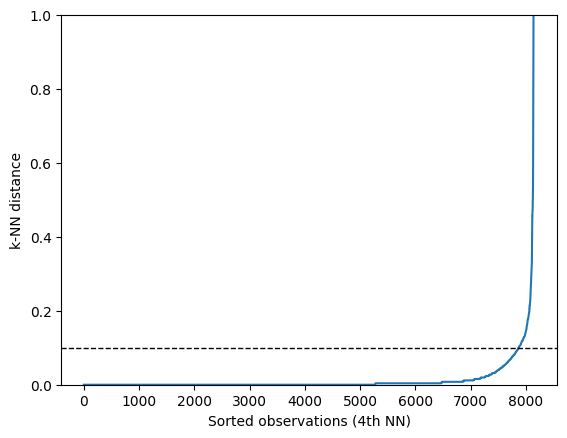

In [16]:
import matplotlib.pyplot as plt
k_dist = sort_neigh_dist[:, 4]
plt.plot(k_dist)
plt.axhline(y=0.1, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.ylim([0, 1])
plt.show()

In [9]:
blocks_k_means.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [7]:
# frame must be the prev frame of label
def separate(label, frame, block_flow_width, block_size):
    foreground = np.ndarray(shape=frames[0].shape, dtype=np.uint8)
    foreground.fill(255)
    background = foreground.copy()

    for i in range(len(label)):
        # get the block position
        block_y = i // block_flow_width
        block_x = i % block_flow_width
        for y in range(block_y * block_size, min((block_y + 1) * block_size, frame.shape[0])):
            for x in range(block_x * block_size, min((block_x + 1) * block_size, frame.shape[1])):
                if label[i] ==  - 1:
                    foreground[y][x] = frame[y][x]
                else:
                    background[y][x] = frame[y][x]


    return foreground, background

foreground, background = separate(blocks_k_means.labels_, frames[-2], block_flow.shape[1], 16)

In [8]:
cv.imshow('Frame',foreground)
cv.waitKey(0)
cv.destroyAllWindows()
cv.waitKey(1)

-1

In [ ]:
cv.imshow('Frame',background)
cv.waitKey(0)
cv.destroyAllWindows()
cv.waitKey(1)

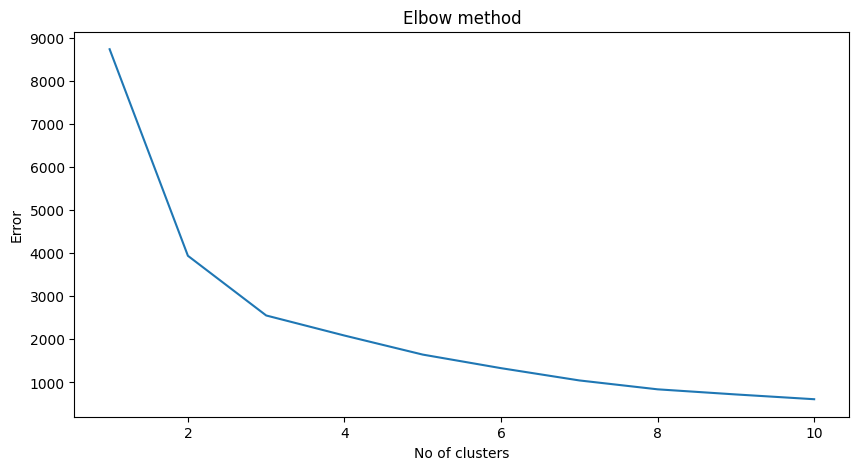

In [7]:
# Error vs num_of_clusters (for KMeans)
from sklearn.cluster import KMeans

blocks_inliers = np.array([tuple(inlier) for inlier in block_flow.reshape(-1, block_flow.shape[-1])])

Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(blocks_inliers)
    kmeans.fit(blocks_inliers)
    Error.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

In [54]:
cv.imshow('Frame',foreground)
cv.waitKey(0)
cv.destroyAllWindows()
cv.waitKey(1)

-1

In [44]:
cv.imshow('Frame',background)
cv.waitKey(0)
cv.destroyAllWindows()
cv.waitKey(1)

-1